In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

aaronmeoded_api_key_path = kagglehub.dataset_download('aaronmeoded/api-key')
aaronmeoded_birddenoising_path = kagglehub.dataset_download('aaronmeoded/birddenoising')

print('Data source import complete.')


# 1. Build an image segmentation model using pytorch

Get dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/My Drive/YU Katz AI/Fall 24/Deep Learning/Project 3/bird_sound_dataset.zip' '/content/'

In [ ]:
!unzip /content/bird_sound_dataset.zip

Archive:  /content/bird_sound_dataset.zip
   creating: new_dataset/test/
   creating: new_dataset/test/images/
  inflating: new_dataset/test/images/XC100135_left.png  
  inflating: new_dataset/test/images/XC101571.png  
  inflating: new_dataset/test/images/XC102188_left.png  
  inflating: new_dataset/test/images/XC103260_right.png  
  inflating: new_dataset/test/images/XC104313_left.png  
  inflating: new_dataset/test/images/XC104652.png  
  inflating: new_dataset/test/images/XC104900.png  
  inflating: new_dataset/test/images/XC105112_left.png  
  inflating: new_dataset/test/images/XC105146_left.png  
  inflating: new_dataset/test/images/XC105278_left.png  
  inflating: new_dataset/test/images/XC105662.png  
  inflating: new_dataset/test/images/XC106043_left.png  
  inflating: new_dataset/test/images/XC106770_left.png  
  inflating: new_dataset/test/images/XC107179_left.png  
  inflating: new_dataset/test/images/XC107340_left.png  
  inflating: new_dataset/test/images/XC108064.png  
 

Dataloader:

In [ ]:
import os

def count_files_in_directory(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])

# Directories
train_dir = "/content/new_dataset/train/images"
valid_dir = "/content/new_dataset/valid/images"
test_dir = "/content/new_dataset/test/images"

# Count files
train_files = count_files_in_directory(train_dir)
valid_files = count_files_in_directory(valid_dir)
test_files = count_files_in_directory(test_dir)

print(f"Train files: {train_files}")
print(f"Valid files: {valid_files}")
print(f"Test files: {test_files}")

Train files: 1000
Valid files: 200
Test files: 300


In [ ]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

In [ ]:
# hyperparameters

image_size = 224
batch_size = 16
learning_rate = 1e-3
num_epochs = 10

In [ ]:
from torchvision.transforms.functional import hflip, vflip, to_tensor, resize, adjust_brightness, adjust_contrast, adjust_saturation
from PIL import Image
import os
from torch.utils.data import Dataset

class BirdDenoisingDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, augment=False, target_size=(224, 224)):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.augment = augment  # Augmentation flag
        self.target_size = target_size
        self.image_files = sorted(os.listdir(images_dir))
        self.mask_files = sorted(os.listdir(masks_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])

        image = Image.open(image_path).convert("RGB")  # Convert to RGB
        mask = Image.open(mask_path).convert("L")  # Convert to grayscale

        # Resize both image and mask to the target size
        image = resize(image, self.target_size)
        mask = resize(mask, self.target_size)

        # Apply augmentations if enabled
        contrast_factor = 2.0  # Fixed contrast factor
        image = adjust_contrast(image, contrast_factor)

        if self.augment:
            # Random horizontal flip
            if torch.rand(1).item() < 0.3:
                image = hflip(image)
                mask = hflip(mask)

            # Random vertical flip
            if torch.rand(1).item() < 0.3:
                image = vflip(image)
                mask = vflip(mask)

            # # Apply ColorJitter (only for RGB images)
            # if image.mode == "RGB":
            #     if torch.rand(1).item() < 0.5:  # 50% probability
            #         brightness_factor = torch.empty(1).uniform_(0.8, 1.2).item()
            #         contrast_factor = torch.empty(1).uniform_(0.8, 1.2).item()
            #         saturation_factor = torch.empty(1).uniform_(0.8, 1.2).item()
            #         image = adjust_brightness(image, brightness_factor)
            #         image = adjust_contrast(image, contrast_factor)
            #         image = adjust_saturation(image, saturation_factor)

        # Apply standard transforms to the image
        if self.transform:
            image = self.transform(image)

        # Convert the mask to a tensor
        mask = to_tensor(mask)

        return image, mask

In [ ]:
# Shared transform for resizing, tensor conversion, and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to target size
    transforms.ToTensor(),          # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Dataset definitions
train_dataset = BirdDenoisingDataset(
    images_dir="/content/new_dataset/train/images",
    masks_dir="/content/new_dataset/train/masks",
    transform=transform,  # Shared transform
    augment=True  # Enable augmentation for training
)

valid_dataset = BirdDenoisingDataset(
    images_dir="/content/new_dataset/valid/images",
    masks_dir="/content/new_dataset/valid/masks",
    transform=transform,  # Shared transform
    augment=False  # No augmentation for validation
)

test_dataset = BirdDenoisingDataset(
    images_dir="/content/new_dataset/test/images",
    masks_dir="/content/new_dataset/test/masks",
    transform=transform,  # Shared transform
    augment=False  # No augmentation for testing
)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

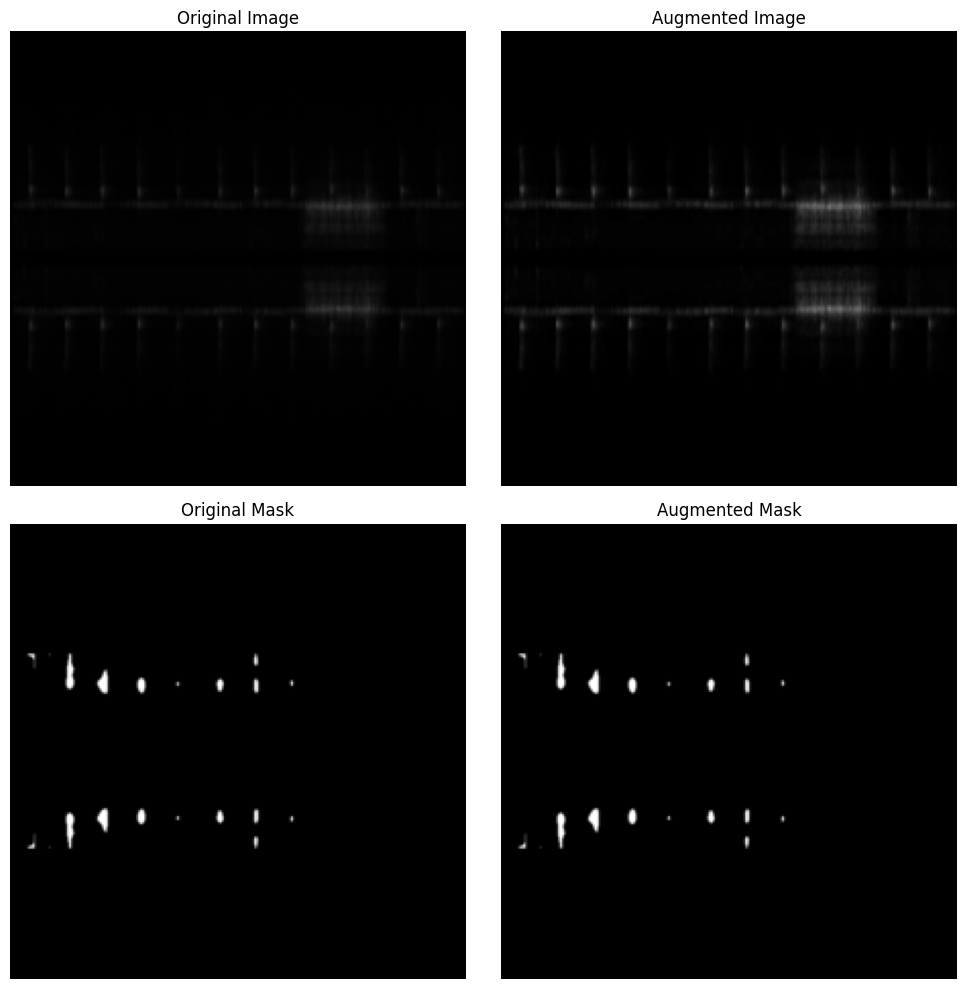

In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import hflip, vflip, to_tensor, resize, adjust_brightness, adjust_contrast, adjust_saturation
import torch

# Function to visualize augmentations
def visualize_augmentations(image_path, mask_path, augment_prob=0, jitter_prob=0.5):
    # Load image and mask
    image = Image.open(image_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")

    # Resize for consistency
    target_size = (224, 224)
    image = resize(image, target_size)
    mask = resize(mask, target_size)

    # Display original image and mask
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs[0, 0].imshow(image)
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis("off")
    axs[1, 0].imshow(mask, cmap="gray")
    axs[1, 0].set_title("Original Mask")
    axs[1, 0].axis("off")

    contrast_factor = 2.0  # Fixed contrast factor
    image = adjust_contrast(image, contrast_factor)

    # Apply augmentations
    if torch.rand(1).item() < augment_prob:
        image = hflip(image)
        mask = hflip(mask)
    if torch.rand(1).item() < augment_prob:
        image = vflip(image)
        mask = vflip(mask)
    if torch.rand(1).item() < jitter_prob:  # Apply ColorJitter
        brightness_factor = torch.empty(1).uniform_(0.8, 1.2).item()
        contrast_factor = torch.empty(1).uniform_(0.8, 1.2).item()
        saturation_factor = torch.empty(1).uniform_(0.8, 1.2).item()
        image = adjust_brightness(image, brightness_factor)
        image = adjust_contrast(image, contrast_factor)
        image = adjust_saturation(image, saturation_factor)

    # Display augmented image and mask
    axs[0, 1].imshow(image)
    axs[0, 1].set_title("Augmented Image")
    axs[0, 1].axis("off")
    axs[1, 1].imshow(mask, cmap="gray")
    axs[1, 1].set_title("Augmented Mask")
    axs[1, 1].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage with an actual image and mask path
example_image_path = "/content/new_dataset/train/images/XC104452_left.png"  # Replace with actual path
example_mask_path = "/content/new_dataset/train/masks/XC104452_left.png"    # Replace with actual path
visualize_augmentations(example_image_path, example_mask_path)


# 2. Train your model using [Bird sound datasets](https://yuad-my.sharepoint.com/personal/youshan_zhang_yu_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fyoushan%5Fzhang%5Fyu%5Fedu%2FDocuments%2FBird%5FSound%5FDataset&ga=1)

## Model

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

class SegmentationModel(nn.Module):
    def __init__(self, num_classes=1):
        super(SegmentationModel, self).__init__()

        # Load ResNet50 as the encoder
        backbone = resnet50(pretrained=True)

        # Encoder layers
        self.layer0 = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool
        )
        self.layer1 = backbone.layer1  # output channels: 256
        self.layer2 = backbone.layer2  # output channels: 512
        self.layer3 = backbone.layer3  # output channels: 1024
        self.layer4 = backbone.layer4  # output channels: 2048

        # Decoder layers (unchanged dimensions)
        self.up1 = nn.ConvTranspose2d(2048, 1280, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up2 = nn.ConvTranspose2d(1280, 640, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up3 = nn.ConvTranspose2d(640, 320, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up4 = nn.ConvTranspose2d(320, 160, kernel_size=3, stride=2, padding=1, output_padding=1)

        # Convs after concatenation to reduce channel dimension (double conv per stage)
        # Original conv layers
        self.conv1 = nn.Conv2d(1280 + 1024, 1280, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(640 + 512, 640, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(320 + 256, 320, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(160 + 64, 160, kernel_size=3, padding=1)

        # Second conv layer for each stage
        self.conv1_2 = nn.Conv2d(1280, 1280, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(640, 640, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(320, 320, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(160, 160, kernel_size=3, padding=1)

        # Shared ReLU
        self.relu = nn.ReLU(inplace=True)

        # Final output layers
        self.final_conv = nn.ConvTranspose2d(160, num_classes, kernel_size=1)
        self.final_upsample = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder forward pass
        x0 = self.layer0(x)   # [B, 64, 56, 56]
        x1 = self.layer1(x0)  # [B, 256, 56, 56]
        x2 = self.layer2(x1)  # [B, 512, 28, 28]
        x3 = self.layer3(x2)  # [B, 1024, 14, 14]
        x4 = self.layer4(x3)  # [B, 2048, 7, 7]

        # Decoder with skip connections and double convs:

        # Stage 1
        x = self.up1(x4)
        x = torch.cat([x, x3], dim=1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv1_2(x)
        x = self.relu(x)

        # Stage 2
        x = self.up2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv2_2(x)
        x = self.relu(x)

        # Stage 3
        x = self.up3(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv3_2(x)
        x = self.relu(x)

        # final stage (Stage 4)
        x = self.up4(x)  # Currently 56x56 -> 112x112
        # Before concatenation
        x0_resized = nn.functional.interpolate(x0, size=(x.size(2), x.size(3)), mode="bilinear", align_corners=False)
        x = torch.cat([x, x0_resized], dim=1)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.conv4_2(x)
        x = self.relu(x)

        # Final output
        x = self.final_conv(x)
        x = self.final_upsample(x)
        x = self.sigmoid(x)

        return x

In [ ]:
import torch

def dice_loss(pred, target, smooth=1):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return 1 - ((2. * intersection + smooth) / (union + smooth))

class BCEWithDiceLoss(nn.Module):
    def __init__(self):
        super(BCEWithDiceLoss, self).__init__()
        self.bce = nn.BCELoss()

    def forward(self, pred, target):
        bce = self.bce(pred, target)
        dice = dice_loss(pred, target)
        return bce + dice

# Define the model
model = SegmentationModel(num_classes=1)  # Instantiate your model

# Initialize loss and optimizer
loss_fn = BCEWithDiceLoss()
# loss_fn = dice_loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s]


NameError: name 'learning_rate' is not defined

In [ ]:
model

SegmentationModel(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256,

In [ ]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, loss_fn, optimizer,  num_epochs=10, device='cuda'):
    model.to(device)

    best_val_loss = float('inf')  # To track the best validation loss

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Training phase
        model.train()
        train_loss = 0.0

        # Add tqdm for training
        train_progress = tqdm(train_loader, desc="Training", leave=False)
        for images, masks in train_progress:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_progress.set_postfix(loss=loss.item())

        train_loss /= len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0

        # Add tqdm for validation
        val_progress = tqdm(val_loader, desc="Validation", leave=False)
        with torch.no_grad():
            for images, masks in val_progress:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, masks)
                val_loss += loss.item()
                val_progress.set_postfix(loss=loss.item())

        val_loss /= len(val_loader)

        # Print losses together
        print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Save the model if it has the best validation loss so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print("Model saved!")
        scheduler.step()

    print("Training complete.")

In [ ]:
train_model(model, train_loader, valid_loader, loss_fn, optimizer, num_epochs=50)

Epoch 1/50


Train Loss: 2.4552, Validation Loss: 0.5741
Model saved!
Epoch 2/50


Train Loss: 0.5447, Validation Loss: 0.5480
Model saved!
Epoch 3/50


Train Loss: 0.4754, Validation Loss: 0.4390
Model saved!
Epoch 4/50


Train Loss: 0.4424, Validation Loss: 0.4195
Model saved!
Epoch 5/50


Train Loss: 0.4128, Validation Loss: 0.4633
Epoch 6/50


Train Loss: 0.3926, Validation Loss: 0.4477
Epoch 7/50


Train Loss: 0.3802, Validation Loss: 0.3737
Model saved!
Epoch 8/50


Train Loss: 0.3781, Validation Loss: 0.4474
Epoch 9/50


Train Loss: 0.3693, Validation Loss: 0.6351
Epoch 10/50


Train Loss: 0.3550, Validation Loss: 0.3737
Epoch 11/50


Train Loss: 0.3524, Validation Loss: 0.3545
Model saved!
Epoch 12/50


Train Loss: 0.3425, Validation Loss: 1.9807
Epoch 13/50


Train Loss: 0.3509, Validation Loss: 0.3492
Model saved!
Epoch 14/50


Train Loss: 0.3410, Validation Loss: 0.3542
Epoch 15/50


Train Loss: 0.3362, Validation Loss: 1.8030
Epoch 16/50


Train Loss: 0.3239, Validation Loss: 0.3477
Model saved!
Epoch 17/50


Train Loss: 0.3172, Validation Loss: 0.3528
Epoch 18/50


Train Loss: 0.3186, Validation Loss: 1.1146
Epoch 19/50


Train Loss: 0.3167, Validation Loss: 2.0910
Epoch 20/50


Train Loss: 0.3155, Validation Loss: 0.3434
Model saved!
Epoch 21/50


Train Loss: 0.3095, Validation Loss: 0.3694
Epoch 22/50


Train Loss: 0.2972, Validation Loss: 0.3685
Epoch 23/50


Train Loss: 0.3008, Validation Loss: 0.3398
Model saved!
Epoch 24/50


Train Loss: 0.2968, Validation Loss: 0.3584
Epoch 25/50


Train Loss: 0.3077, Validation Loss: 0.3576
Epoch 26/50


Train Loss: 0.2850, Validation Loss: 0.3436
Epoch 27/50


Train Loss: 0.2809, Validation Loss: 0.3400
Epoch 28/50


KeyboardInterrupt: 

In [ ]:
learning_rate=1e-4
epochs = 30
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
train_model(model, train_loader, valid_loader, loss_fn, optimizer, num_epochs=epochs)

Epoch 1/30


Train Loss: 0.2644, Validation Loss: 0.3261


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Model saved!
Epoch 2/30


Train Loss: 0.2571, Validation Loss: 0.3307
Epoch 3/30


Train Loss: 0.2557, Validation Loss: 0.3290
Epoch 4/30


Train Loss: 0.2513, Validation Loss: 0.3303
Epoch 5/30


Train Loss: 0.2520, Validation Loss: 0.3288
Epoch 6/30


Train Loss: 0.2488, Validation Loss: 0.3344
Epoch 7/30


Train Loss: 0.2462, Validation Loss: 0.3313
Epoch 8/30


Train Loss: 0.2462, Validation Loss: 0.3281
Epoch 9/30


Train Loss: 0.2411, Validation Loss: 0.3275
Epoch 10/30


Train Loss: 0.2401, Validation Loss: 0.3308
Epoch 11/30


Train Loss: 0.2394, Validation Loss: 0.3984
Epoch 12/30


Train Loss: 0.2393, Validation Loss: 0.3315
Epoch 13/30


Train Loss: 0.2354, Validation Loss: 0.3337
Epoch 14/30


Train Loss: 0.2325, Validation Loss: 0.3330
Epoch 15/30


Train Loss: 0.2310, Validation Loss: 0.3306
Epoch 16/30


Train Loss: 0.2283, Validation Loss: 0.3294
Epoch 17/30


Train Loss: 0.2273, Validation Loss: 0.3351
Epoch 18/30


KeyboardInterrupt: 

# 3.Evaluate your model using the test images

In [ ]:
def test_model(model, test_loader, device='cuda'):
    """
    Test the segmentation model on the test set.

    Args:
        model (torch.nn.Module): Trained segmentation model.
        test_loader (DataLoader): DataLoader for the test set.
        loss_fn (callable): Loss function used for evaluation.
        device (str): Device to run the model ('cuda' or 'cpu').

    Returns:
        float: Mean IoU score across the test set.
    """
    model.to(device)
    model.eval()

    iou_scores = []
    test_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Testing", leave=False):
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate loss (optional)
            loss = loss_fn(outputs, masks)
            test_loss += loss.item()

            # Threshold outputs to binary for IoU calculation
            outputs = (outputs > 0.5).float()  # Binary prediction
            intersection = (outputs * masks).sum(dim=(2, 3))
            union = (outputs + masks).sum(dim=(2, 3)) - intersection
            iou = (intersection + 1e-6) / (union + 1e-6)  # Avoid division by zero
            iou_scores.append(iou.mean().item())

    # Compute average test loss and IoU score
    test_loss /= len(test_loader)
    mean_iou = sum(iou_scores) / len(iou_scores)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Mean IoU Score: {mean_iou:.4f}")

    return mean_iou

# 4. Your IoU score should be higher than 60

In [ ]:
# Step 1: Define the model architecture
best_model = SegmentationModel(num_classes=1)  # Use the same architecture as during training

# Step 2: Load the saved best model weights
best_model.load_state_dict(torch.load('best_model.pth'))

# Step 3: Pass the loaded model into the test function
mean_iou = test_model(best_model, test_loader)
print(f"Mean IoU on Test Set: {mean_iou:.4f}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-31-b358183158da>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detail

Test Loss: 0.3305
Mean IoU Score: 0.6300
Mean IoU on Test Set: 0.6300


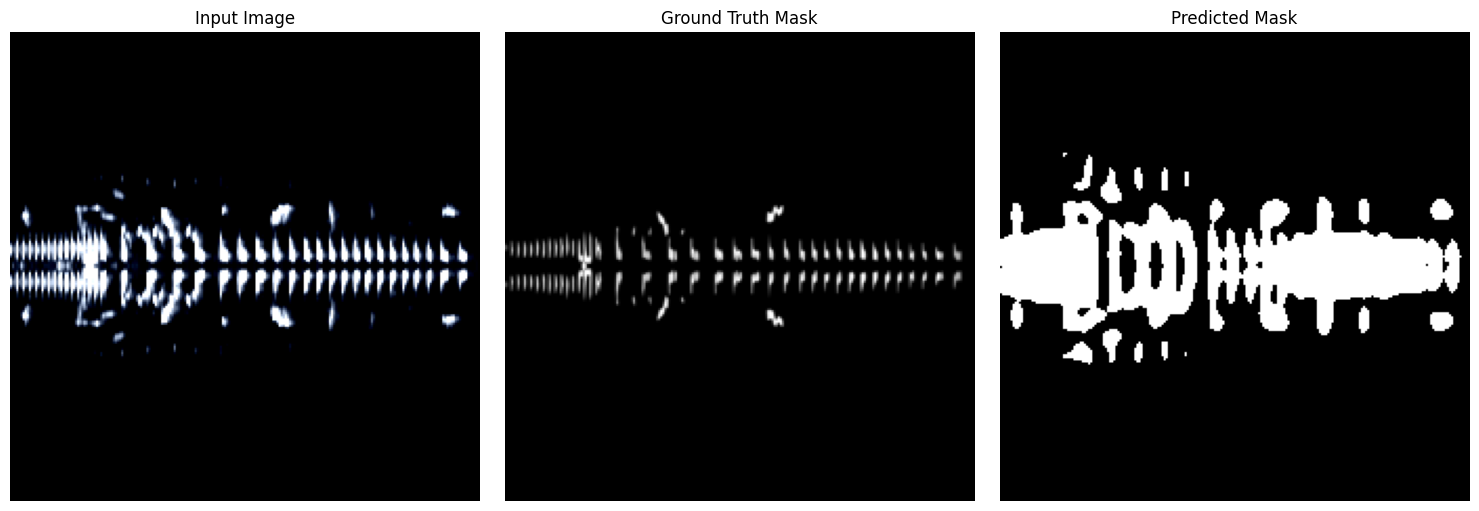

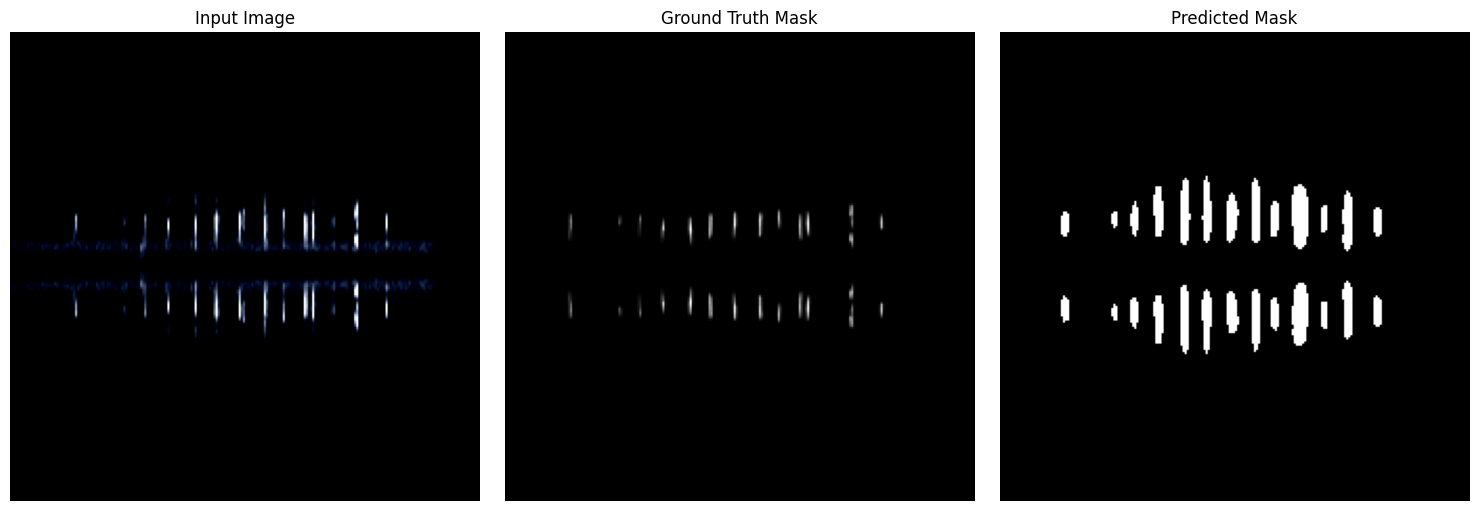

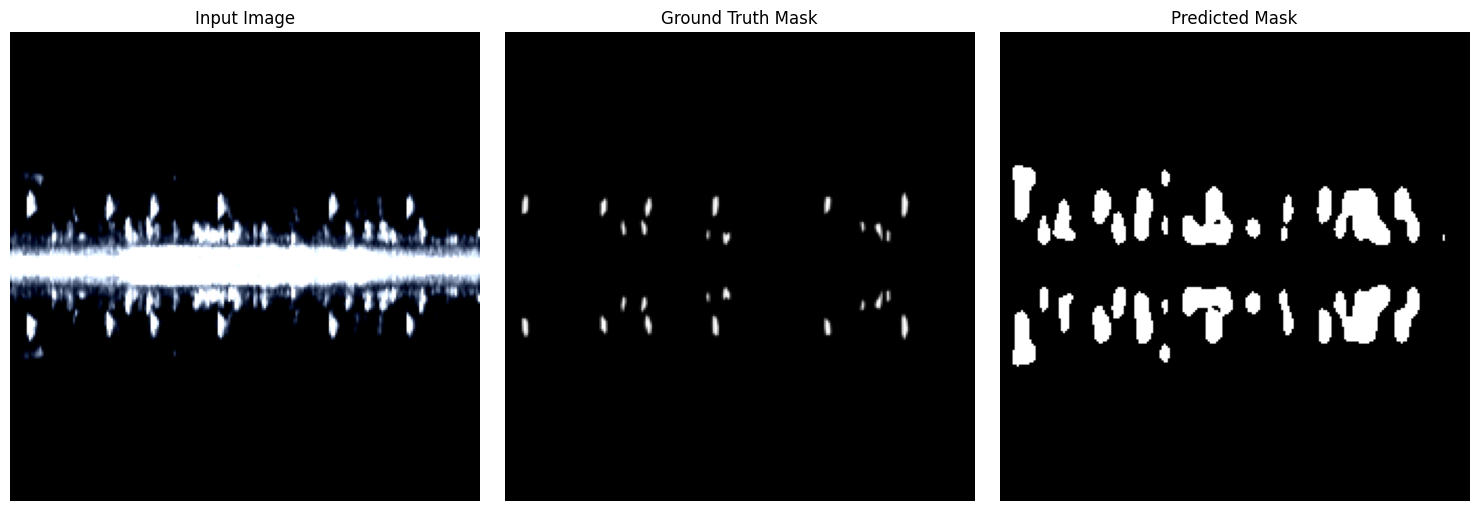

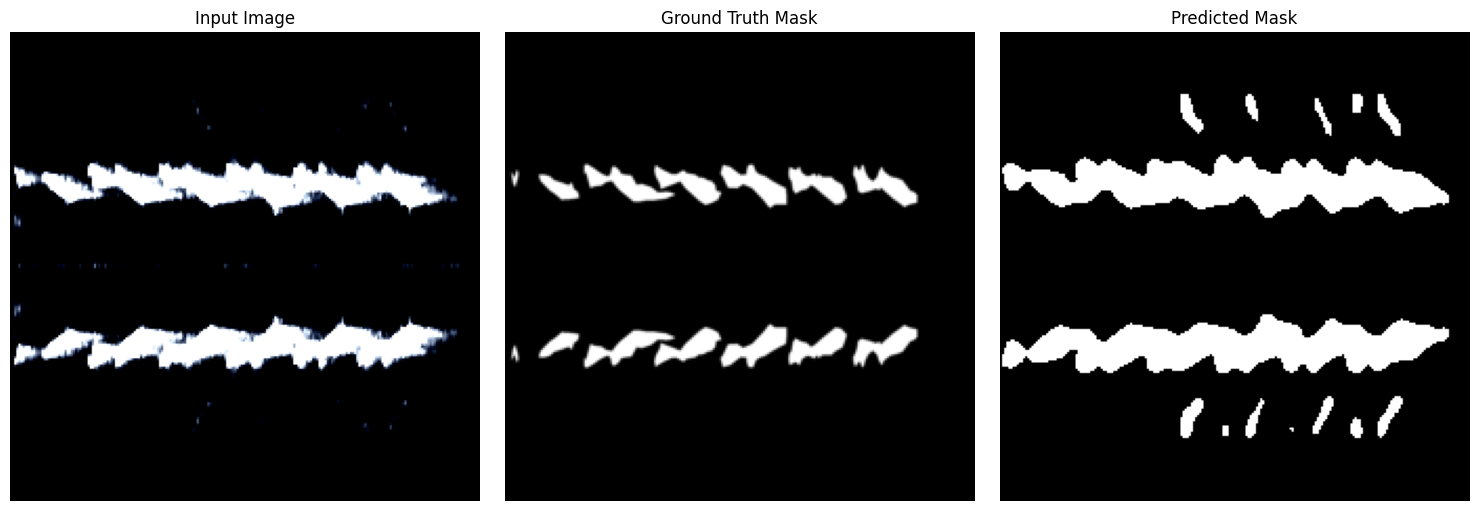

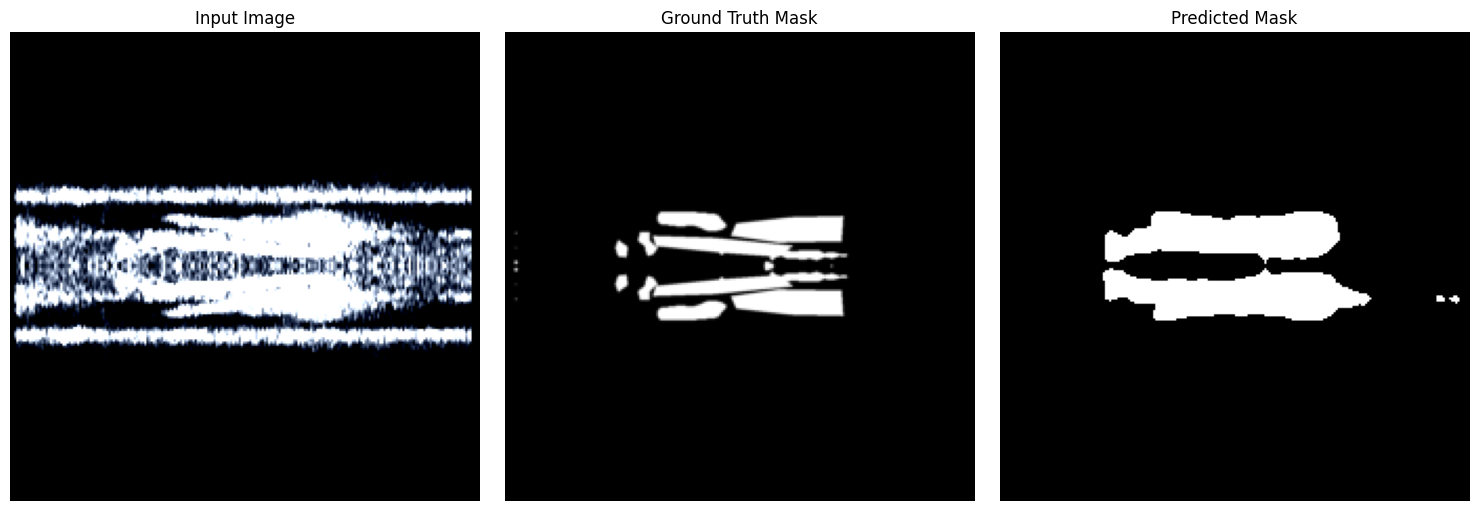

In [ ]:
visualize_predictions(best_model, test_loader)

# 5. Write a 3-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.


Paper link: https://www.researchgate.net/publication/387187819_Segmentation-Based_Bird_Audio_Denoising


Model link: https://drive.google.com/file/d/1xfsOes31qgkOTd2u92VouDCjRLsOxnCL/view?usp=sharing

# 6. Grading rubric



(1). Code ------- 20 points (you also need to upload your final model as a pt file, and add paper link)



(2). Grammer ---- 20 points



(3). Introduction & related work --- 10 points



(4). Method  ---- 20 points



(5). Results ---- 20 points



     > = 0.85 -->10 points

     < 0.8  --> 0 points

     >= 0.8 & < 0.85  --> 2 point/0.01 higher

     



(6). Discussion - 10 points